# Data Preprocessing of the Kaggle House Price Dataset

# Import all Libraries

In [1]:
# pandas: handle the datasets in the pandas dataframe for data processing and analysis
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: apply high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

import sklearn
print("sklearn version: {}". format(sklearn.__version__))

# matplotlib: standard library to create visualizations
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

# seaborn: advanced visualization library to create more advanced charts
import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

# turn out warnings for better reading in the Jupyter notebbok
pd.options.mode.chained_assignment = None  # default='warn'

pandas version: 1.4.2
numpy version: 1.21.5
sklearn version: 1.0.2
matplotlib version: 3.5.1
seaborn version: 0.11.2


# Load Training and Test Dataset

In [2]:
# load training and test dataset
df_train = pd.read_csv('../01_RawData/train.csv')
df_test = pd.read_csv('../01_RawData/test.csv')

# Fix or Remove Missing Values
From the statistic report we already saw that there are missing values in the training and test dataset. With the following function you get a better overview of the missing values.

In [3]:
def find_missing_values(df):
    """
    find missing values in the dataframe
    return the features with missing values, the total number of missing values and the percentage of missing values
    """
    total = df.isnull().sum().sort_values(ascending=False) # compute the total number of missing values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) # compute the percentage of missing values
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # add all information to one dataframe
    missing_data = missing_data[missing_data['Total']>0] # filter the dataframe to only the features with missing values
    return missing_data

For features with more then 30% of missing values, we have to delete them, because there is no way to imput the missing values with confidence.

For the rest of the missing values, we will try to imput the missing values either with imputation methods or via an algorithm.

In [4]:
df_missing_values_train = find_missing_values(df_train)
df_missing_values_train

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [5]:
df_missing_values_test = find_missing_values(df_test)
df_missing_values_test

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461
GarageCond,78,0.053461


## Drop features with more then 30% of missing values

In [6]:
# drop features with more then 30% of missing values
df_train = df_train.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)
df_test = df_test.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)

## Imput Numeric and Categoric Features

In [7]:
num_features = list(df_test.describe())
cat_features = list(df_test.describe(include=['O']))

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

df_missing_values_all_num = list(set(list(df_missing_values_train.index) + list(df_missing_values_test.index)).intersection(num_features))

imputer_num = imputer.fit(df_train[df_missing_values_all_num])

df_train[df_missing_values_all_num] = imputer_num.transform(df_train[df_missing_values_all_num])
df_test[df_missing_values_all_num] = imputer_num.transform(df_test[df_missing_values_all_num])

In [9]:
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)

df_missing_values_all_cat = list(set(list(df_missing_values_train.index) + list(df_missing_values_test.index)).intersection(cat_features))

imputer_cat = imputer.fit(df_train[df_missing_values_all_cat])

df_train[df_missing_values_all_cat] = imputer_cat.transform(df_train[df_missing_values_all_cat])
df_test[df_missing_values_all_cat] = imputer_cat.transform(df_test[df_missing_values_all_cat])

# Feature Engineering

In [10]:
def find_season(month, hemisphere):
    if hemisphere == 'Southern':
        season_month_south = {
            12:'Summer', 1:'Summer', 2:'Summer',
            3:'Autumn', 4:'Autumn', 5:'Autumn',
            6:'Winter', 7:'Winter', 8:'Winter',
            9:'Spring', 10:'Spring', 11:'Spring'}
        return season_month_south.get(month)
        
    elif hemisphere == 'Northern':
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')

In [11]:
def percentage(row):
    type_count = row[0]
    total_types = row[1]
    if total_types is None or total_types == 0:
        return 0
    else:
        return 100 * (int(type_count) / int(total_types))

In [12]:
df_train["TotalFS"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"] + df_train["GrLivArea"]
df_test["TotalFS"] = df_test["1stFlrSF"] + df_test["2ndFlrSF"] + df_test["GrLivArea"]

df_train["MeanSFRoom"] = round(df_train["TotalFS"] / df_train["TotRmsAbvGrd"], 0)
df_test["MeanSFRoom"] = round(df_test["TotalFS"] / df_test["TotRmsAbvGrd"], 0)

df_train["YearsBeforeWork"] = df_train["YearRemodAdd"] - df_train["YearBuilt"]
df_test["YearsBeforeWork"] = df_test["YearRemodAdd"] - df_test["YearBuilt"]

df_train["TotalBath"] = df_train["FullBath"] + 0.5*df_train["HalfBath"] + df_train["BsmtFullBath"] + 0.5*df_train["BsmtHalfBath"]
df_test["TotalBath"] = df_test["FullBath"] + 0.5*df_test["HalfBath"] + df_test["BsmtFullBath"] + 0.5*df_test["BsmtHalfBath"]

df_train["TotalFS_TotalBath"] = df_train["TotalFS"] / df_train["TotalBath"]
df_test["TotalFS_TotalBath"] = df_test["TotalFS"] / df_test["TotalBath"]

df_train["GarageArea_GarageCars"] = df_train["GarageArea"] / df_train["GarageCars"]
df_test["GarageArea_GarageCars"] = df_test["GarageArea"] / df_test["GarageCars"]

df_train["TotalPorchSF"] = df_train["OpenPorchSF"] + df_train["EnclosedPorch"] + df_train["3SsnPorch"] + df_train["ScreenPorch"]
df_test["TotalPorchSF"] = df_test["OpenPorchSF"] + df_test["EnclosedPorch"] + df_test["3SsnPorch"] + df_test["ScreenPorch"]

df_train["YearsBeforeSold"] = df_train["YrSold"] - df_train["YearBuilt"]
df_test["YearsBeforeSold"] = df_test["YrSold"] - df_test["YearBuilt"]

df_train["SeasonSold"] = df_train["MoSold"].apply(lambda x: find_season(x, "Northern"))
df_test["SeasonSold"] = df_test["MoSold"].apply(lambda x: find_season(x, "Northern"))


df_train['PoolArea_bin'] = df_train['PoolArea'].apply(lambda x: 1 if x>0 else 0)
df_test['PoolArea_bin'] = df_test['PoolArea'].apply(lambda x: 1 if x>0 else 0)

df_train['TotalPorchSF_bin'] = df_train['TotalPorchSF'].apply(lambda x: 1 if x>0 else 0)
df_test['TotalPorchSF_bin'] = df_test['TotalPorchSF'].apply(lambda x: 1 if x>0 else 0)

df_train['GarageArea_bin'] = df_train['GarageArea'].apply(lambda x: 1 if x>0 else 0)
df_test['GarageArea_bin'] = df_test['GarageArea'].apply(lambda x: 1 if x>0 else 0)

df_train['MiscVal_bin'] = df_train['MiscVal'].apply(lambda x: 1 if x>0 else 0)
df_test['MiscVal_bin'] = df_test['MiscVal'].apply(lambda x: 1 if x>0 else 0)


df_train.replace([np.inf, -np.inf], 0, inplace=True)
df_test.replace([np.inf, -np.inf], 0, inplace=True)

# Fix Skewed Features

In [13]:
from scipy.stats import skew
def compute_skewed_features(df):
    """
    compute the skewness of all numeric features and the total number of unique values
    return only the features that have a relevant skewness
    """
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = pd.DataFrame(index=numeric_feats, columns=['skewness', 'unique_values'])
    skewed_feats['skewness'] = df[numeric_feats].apply(lambda x: skew(x))
    skewed_feats['unique_values'] = df.nunique()
    skewed_feats['percentage_0'] = df[df == 0].count(axis=0)/len(df.index)
    skewed_feats = skewed_feats[
        ((skewed_feats['skewness'] > 3) | (skewed_feats['skewness'] < -3)) & 
        (skewed_feats['unique_values'] > 10) &
        (skewed_feats['percentage_0'] < 0.5)
        ]

    return skewed_feats

In [14]:
skewed_feats = compute_skewed_features(df_train)
skewed_feats

,skewness,unique_values,percentage_0
LotArea,12.195142,1073,0.0


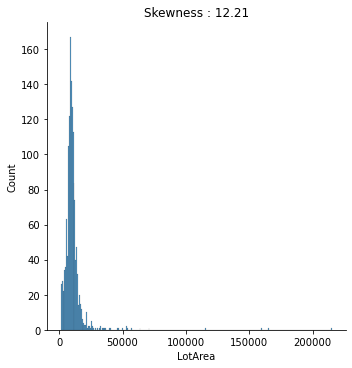

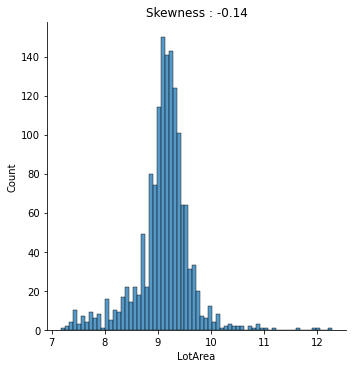

In [15]:
for feature in list(skewed_feats.index):
    
    # view the distribution of Fare after the log transformation with the skewness
    g = sns.displot(df_train[feature])
    plt.title("Skewness : %.2f"%(df_train[feature].skew()))
    plt.show()
    
    # apply log transformation
    # the not transformed data that contains 0
    # after the transformation we have -inf values that have to be replaced by 0
    df_train[feature] = df_train[feature].apply(np.log)
    df_train[feature][np.isneginf(df_train[feature])]=0
    
    if feature != "SalePrice":
        df_test[feature] = df_test[feature].apply(np.log)
        df_test[feature][np.isneginf(df_test[feature])]=0

    # view the distribution of Fare after the log transformation with the skewness
    g = sns.displot(df_train[feature])
    plt.title("Skewness : %.2f"%(df_train[feature].skew()))
    plt.show()

# Feature Selection

In [16]:
df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)

# Transform Categoric Features into Numeric

In [17]:
# features for Label Encoder with inherent order to the categorical values

map_Utilities = {
    'ELO': 0,
    'NoSeWa': 1,
    'NoSewr': 2,
    'AllPub': 3
}
df_train["Utilities"] = df_train["Utilities"].map(map_Utilities)
df_test["Utilities"] = df_test["Utilities"].map(map_Utilities)


map_LandSlope = {
    'Gtl': 0,
    'Mod': 1,
    'Sev': 2
}
df_train["LandSlope"] = df_train["LandSlope"].map(map_LandSlope)
df_test["LandSlope"] = df_test["LandSlope"].map(map_LandSlope)


map_HouseStyle = {
    '1Story': 0,
    '1.5Fin': 1,
    '1.5Unf': 2,
    '2Story': 3,
    '2.5Fin': 4,
    '2.5Unf': 5,
    'SFoyer': 6,
    'SLvl': 7
}
df_train["HouseStyle"] = df_train["HouseStyle"].map(map_HouseStyle)
df_test["HouseStyle"] = df_test["HouseStyle"].map(map_HouseStyle)


map_ExterQual = {
    'Po': 0,
    'Fa': 1,
    'TA': 2,
    'Gd': 3,
    'Ex': 4
}
df_train["ExterQual"] = df_train["ExterQual"].map(map_ExterQual)
df_test["ExterQual"] = df_test["ExterQual"].map(map_ExterQual)

df_train["ExterCond"] = df_train["ExterCond"].map(map_ExterQual)
df_test["ExterCond"] = df_test["ExterCond"].map(map_ExterQual)


map_BsmtQual = {
    'NA': 0,
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}
df_train["BsmtQual"] = df_train["BsmtQual"].map(map_BsmtQual)
df_test["BsmtQual"] = df_test["BsmtQual"].map(map_BsmtQual)

df_train["BsmtCond"] = df_train["BsmtCond"].map(map_BsmtQual)
df_test["BsmtCond"] = df_test["BsmtCond"].map(map_BsmtQual)

# df_train["FireplaceQu"] = df_train["FireplaceQu"].map(map_BsmtQual)
# df_test["FireplaceQu"] = df_test["FireplaceQu"].map(map_BsmtQual)

df_train["GarageQual"] = df_train["GarageQual"].map(map_BsmtQual)
df_test["GarageQual"] = df_test["GarageQual"].map(map_BsmtQual)

df_train["GarageCond"] = df_train["GarageCond"].map(map_BsmtQual)
df_test["GarageCond"] = df_test["GarageCond"].map(map_BsmtQual)


map_BsmtExposure = {
    'NA': 0,
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4
}
df_train["BsmtExposure"] = df_train["BsmtExposure"].map(map_BsmtExposure)
df_test["BsmtExposure"] = df_test["BsmtExposure"].map(map_BsmtExposure)


map_BsmtFinType1 = {
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].map(map_BsmtFinType1)
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].map(map_BsmtFinType1)

df_train["BsmtFinType2"] = df_train["BsmtFinType2"].map(map_BsmtFinType1)
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].map(map_BsmtFinType1)


map_HeatingQC = {
    'Po': 0,
    'Fa': 1,
    'TA': 2,
    'Gd': 3,
    'Ex': 4
}
df_train["HeatingQC"] = df_train["HeatingQC"].map(map_HeatingQC)
df_test["HeatingQC"] = df_test["HeatingQC"].map(map_HeatingQC)

df_train["KitchenQual"] = df_train["KitchenQual"].map(map_HeatingQC)
df_test["KitchenQual"] = df_test["KitchenQual"].map(map_HeatingQC)


map_Functional = {
    'Sal': 0,
    'Sev': 1,
    'Maj2': 2,
    'Maj1': 3,
    'Mod': 4,
    'Min2': 5,
    'Min1': 6,
    'Typ': 7
}
df_train["Functional"] = df_train["Functional"].map(map_Functional)
df_test["Functional"] = df_test["Functional"].map(map_Functional)


map_GarageFinish = {
    'NA': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}
df_train["GarageFinish"] = df_train["GarageFinish"].map(map_GarageFinish)
df_test["GarageFinish"] = df_test["GarageFinish"].map(map_GarageFinish)


map_PavedDrive = {
    'Y': 0,
    'P': 1,
    'N': 2
}
df_train["PavedDrive"] = df_train["PavedDrive"].map(map_PavedDrive)
df_test["PavedDrive"] = df_test["PavedDrive"].map(map_PavedDrive)


map_PoolQC = {
    'NA': 0,
    'Fa': 1,
    'TA': 2,
    'Gd': 3,
    'Ex': 4
}
# df_train["PoolQC"] = df_train["PoolQC"].map(map_PoolQC)
# df_test["PoolQC"] = df_test["PoolQC"].map(map_PoolQC)


map_Fence = {
    'NA': 0,
    'MnWw': 1,
    'GdWo': 2,
    'MnPrv': 3,
    'GdPrv': 4
}
# df_train["Fence"] = df_train["Fence"].map(map_Fence)
# df_test["Fence"] = df_test["Fence"].map(map_Fence)


map_SeasonSold = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Autumn': 3
}
df_train["SeasonSold"] = df_train["SeasonSold"].map(map_SeasonSold)
df_test["SeasonSold"] = df_test["SeasonSold"].map(map_SeasonSold)




In [18]:
df_train[df_train.dtypes[df_train.dtypes == "object"].index].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
LotConfig         5
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
Foundation        6
Heating           6
CentralAir        2
Electrical        5
GarageType        6
SaleType          9
SaleCondition     6
dtype: int64

In [19]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop="if_binary",
    )
cat_vars = df_train.dtypes[df_train.dtypes == "object"].index

ohe_train = pd.DataFrame(enc.fit_transform(df_train[cat_vars]), columns=enc.get_feature_names())
print("df_train old shape: " + str(df_train.shape))
print("ohe_train old shape: " + str(ohe_train.shape))
df_train = pd.concat([df_train, ohe_train], axis=1).drop(cat_vars, axis=1)
print("df_train new shape: " + str(df_train.shape))

ohe_test = pd.DataFrame(enc.transform(df_test[cat_vars]), columns=enc.get_feature_names())
print("df_test old shape: " + str(df_test.shape))
print("ohe_test old shape: " + str(ohe_test.shape))
df_test = pd.concat([df_test, ohe_test], axis=1).drop(cat_vars, axis=1)
print("df_test new shape: " + str(df_test.shape))

df_train old shape: (1460, 88)
ohe_train old shape: (1460, 154)
df_train new shape: (1460, 221)
df_test old shape: (1459, 87)
ohe_test old shape: (1459, 154)
df_test new shape: (1459, 220)


e:\programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
e:\programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Feature Selection

In [20]:
from sklearn.feature_selection import VarianceThreshold

# remove all features that are either one or zero in more than 95% of the samples
sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
sel_features = list(df_train)

# remove the label from the list of columns
sel_features.remove("SalePrice")

# fit the VarianceThreshold object to the training data
sel.fit(df_train[sel_features])

# get the column names after the variance threshold reduction
sel_features_reduced = [sel_features[i] for i in sel.get_support(indices=True)]

# create the training and test dataset by transform the datasets to the variance threshold object
df_train_ = pd.DataFrame(sel.transform(df_train[sel_features]), columns=sel_features_reduced)
# dont forget to join the label back to the training data
df_train = pd.concat([df_train_, df_train["SalePrice"]], axis=1)
df_test = pd.DataFrame(sel.transform(df_test[sel_features]), columns=sel_features_reduced)

In [21]:
print(f"df_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

df_train shape: (1460, 113)
df_test shape: (1459, 112)


In [22]:
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation higher than 0.9 or lower -0.9
to_drop = [column for column in upper.columns if any((upper[column] > 0.9) | (upper[column] < -0.9))]

for element in to_drop:
    column_list = list(df_train.columns[np.where(
        (df_train.corrwith(df_train[element]) > 0.9) |
        (df_train.corrwith(df_train[element]) < -0.9))])
    column_list.remove(element)
    for column in column_list:
        print(str(element) + " <-> " + str(column) + ": " + str(df_train[element].corr(df_train[column])))

C:\Users\chris\AppData\Local\Temp\ipykernel_26780\1501349958.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


TotalFS <-> GrLivArea: 0.9989376478274354
YearsBeforeSold <-> YearBuilt: -0.9990359444033197
x2_Reg <-> x2_IR1: -0.9259589789196655
x9_Hip <-> x9_Gable: -0.9334615823692294
x12_MetalSd <-> x11_MetalSd: 0.9730651937625284
x12_VinylSd <-> x11_VinylSd: 0.9775248873036368
x20_Partial <-> x19_New: 0.9868189596845173


In [23]:
df_train.drop(['GrLivArea', 'YearBuilt', 'x2_IR1', 'x9_Gable', 'x11_MetalSd', 'x11_VinylSd', 'x19_New'], axis=1, inplace=True)
df_test.drop(['GrLivArea', 'YearBuilt', 'x2_IR1', 'x9_Gable', 'x11_MetalSd', 'x11_VinylSd', 'x19_New'], axis=1, inplace=True)

In [24]:
print(f"df_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

df_train shape: (1460, 106)
df_test shape: (1459, 105)


# Fix or Remove Missing Values

In [25]:
df_missing_values_train = find_missing_values(df_train)
df_missing_values_train

,Total,Percent
GarageArea_GarageCars,81,0.055479


In [26]:
df_missing_values_train = find_missing_values(df_train)
df_missing_values_train

,Total,Percent
GarageArea_GarageCars,81,0.055479


In [27]:
df_train["GarageArea_GarageCars"].fillna(0, inplace=True)
df_test["GarageArea_GarageCars"].fillna(0, inplace=True)

# Save Prepared Dataset after Complete Data Preprocessing

In [28]:
# save prepared dataset as pickle file
df_train.to_pickle('df_train_prepared_reduced.pkl')
df_test.to_pickle('df_test_prepared_reduced.pkl')